In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

from ngram import *
from baselines import *
from error_analysis import *
from deep_learning import *
pd.options.mode.chained_assignment = None


Using TensorFlow backend.


### Load Annotated Data

In [2]:
task = 'recipient'
xtype = 'ngrams'
ytype = 'empirical_dist'
n_classes = 2

time: 2.26 ms


In [3]:
data = load_comments_and_labels(task)

time: 1min 50s


### NGram Preprocessing

In [4]:
feature_pipeline =  Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,5), analyzer = 'char', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('to_dense', DenseTransformer()), 
])

X_comments, _ = assemble_data(data, 'comments', ytype, splits = ['train'])
preprocessor = feature_pipeline.fit(X_comments)
data = apply_transform(data, 'comments', preprocessor, xtype)

X_train, y_train = assemble_data(data, xtype, ytype, splits = ['train'])
X_test, y_test = assemble_data(data, xtype, 'empirical_dist', splits = ['test'])

time: 4min 52s


### Define Model

In [5]:
clf =  KerasClassifier(build_fn=make_MLP, output_dim = n_classes, input_dim = 10000)

time: 13.2 ms


### Deep EDP Hyper-Parameter tuning

In [6]:
# Deep EDP

param_grid = {
    'l': (0, 0.00001, 0.0001, 0.001),
    'nb_epoch' : (1,),
    'batch_size': (100,),
    'layers': ([50, 10],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/1
20847/20847 [==============================] - 6s     
Epoch 1/1
20847/20847 [==============================] - 6s     
Epoch 1/1
20847/20847 [==============================] - 6s     
Epoch 1/1
20847/20847 [==============================] - 6s     

Best parameters set found:
{'l': 0, 'batch_size': 100, 'layers': [50, 10], 'nb_epoch': 1} 0.967447048349


Grid scores:
0.96745 (+/-0.00000) for {'l': 0, 'batch_size': 100, 'layers': [50, 10], 'nb_epoch': 1}
0.96513 (+/-0.00000) for {'l': 1e-05, 'batch_size': 100, 'layers': [50, 10], 'nb_epoch': 1}
0.96142 (+/-0.00000) for {'l': 0.0001, 'batch_size': 100, 'layers': [50, 10], 'nb_epoch': 1}
0.95449 (+/-0.00000) for {'l': 0.001, 'batch_size': 100, 'layers': [50, 10], 'nb_epoch': 1}
time: 3min 1s


Seems, like we don't need to regularize at one epoch. Lets try more epochs.

In [7]:
# Deep EDP
param_grid = {
    'l': (0, 0.00001, 0.0001, 0.001),
    'nb_epoch' : (2,),
    'batch_size': (100,),
    'layers': ([50, 10],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/2
48643/48643 [==============================] - 26s - loss: 0.1283 - acc: 0.9443    
Epoch 2/2
20847/20847 [==============================] - 6s     
Epoch 1/2
48643/48643 [==============================] - 25s - loss: 0.1440 - acc: 0.9244    
Epoch 2/2
20847/20847 [==============================] - 6s     
Epoch 1/2
48643/48643 [==============================] - 25s - loss: 0.1581 - acc: 0.9243    
Epoch 2/2
20847/20847 [==============================] - 6s     
Epoch 1/2
48643/48643 [==============================] - 24s - loss: 0.2862 - acc: 0.9219    
Epoch 2/2
20847/20847 [==============================] - 6s     

Best parameters set found:
{'l': 0, 'batch_size': 100, 'layers': [50, 10], 'nb_epoch': 2} 0.97115421842


Grid scores:
0.97115 (+/-0.00000) for {'l': 0, 'batch_size': 100, 'layers': [50, 10], 'nb_epoch': 2}
0.96789 (+/-0.00000) for {'l': 1e-05, 'batch_size': 100, 'layers': [50, 10], 'nb_epoch': 2}
0.96326 (+/-0.00000) for {'l': 0.0001, 'batch_size': 100, 'layer

Same pattern. Results improved for lower reg. Lets try more epochs.

In [8]:
# Deep EDP
param_grid = {
    'l': (0, 0.00001, 0.0001, 0.001),
    'nb_epoch' : (4,),
    'batch_size': (100,),
    'layers': ([50, 10],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/4
48643/48643 [==============================] - 24s - loss: 0.1304 - acc: 0.9447    
Epoch 2/4
48643/48643 [==============================] - 21s - loss: 0.0675 - acc: 0.9630    
Epoch 3/4
48643/48643 [==============================] - 20s - loss: 0.0615 - acc: 0.9667    
Epoch 4/4
20847/20847 [==============================] - 6s     
Epoch 1/4
48643/48643 [==============================] - 24s - loss: 0.1393 - acc: 0.9449    
Epoch 2/4
48643/48643 [==============================] - 21s - loss: 0.0755 - acc: 0.9627    
Epoch 3/4
48643/48643 [==============================] - 21s - loss: 0.0701 - acc: 0.9651    
Epoch 4/4
20847/20847 [==============================] - 6s     
Epoch 1/4
48643/48643 [==============================] - 24s - loss: 0.1548 - acc: 0.9270    
Epoch 2/4
48643/48643 [==============================] - 21s - loss: 0.0933 - acc: 0.9533    
Epoch 3/4
48643/48643 [==============================] - 21s - loss: 0.0889 - acc: 0.9594    
Epoch 4/4
20847/20847 [=

Same pattern still, although performance went a bit down. Lets push the epochs even further.

In [9]:
# Deep EDP
param_grid = {
    'l': (0.00001,),
    'nb_epoch' : (8,16),
    'batch_size': (100,),
    'layers': ([50, 10],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/8
48643/48643 [==============================] - 24s - loss: 0.1648 - acc: 0.9418    
Epoch 2/8
48643/48643 [==============================] - 21s - loss: 0.0795 - acc: 0.9604    
Epoch 3/8
48643/48643 [==============================] - 21s - loss: 0.0732 - acc: 0.9628    
Epoch 4/8
48643/48643 [==============================] - 23s - loss: 0.0696 - acc: 0.9643    
Epoch 5/8
48643/48643 [==============================] - 23s - loss: 0.0667 - acc: 0.9666    
Epoch 6/8
48643/48643 [==============================] - 23s - loss: 0.0641 - acc: 0.9676    
Epoch 7/8
48643/48643 [==============================] - 22s - loss: 0.0619 - acc: 0.9689    
Epoch 8/8
20847/20847 [==============================] - 7s     
Epoch 1/16
48643/48643 [==============================] - 24s - loss: 0.1417 - acc: 0.9449    
Epoch 2/16
48643/48643 [==============================] - 21s - loss: 0.0754 - acc: 0.9619    
Epoch 3/16
48643/48643 [==============================] - 21s - loss: 0.0696 - acc: 0.9

Right now, 2 epochs and no regularization is best. Lets add more layers.

In [10]:
# Deep EDP
param_grid = {
    'l': (0.00001,),
    'nb_epoch' : (2,),
    'batch_size': (100,),
    'layers': ([50, 50],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/2
48643/48643 [==============================] - 26s - loss: 0.1219 - acc: 0.9467    
Epoch 2/2
20847/20847 [==============================] - 6s     

Best parameters set found:
{'l': 1e-05, 'batch_size': 100, 'layers': [50, 50], 'nb_epoch': 2} 0.971459354387


Grid scores:
0.97146 (+/-0.00000) for {'l': 1e-05, 'batch_size': 100, 'layers': [50, 50], 'nb_epoch': 2}
time: 1min 18s


Adding more layers did not help.

### Linear EDP Tuning

In [11]:
# Linear EDP
param_grid = {
    'l': (0,),
    'nb_epoch' : (1,2,4,8,16),
    'batch_size': (100,),
    'layers': ([],),
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/1
20847/20847 [==============================] - 5s     
Epoch 1/2
48643/48643 [==============================] - 13s - loss: 0.1610 - acc: 0.9357    
Epoch 2/2
20847/20847 [==============================] - 4s     
Epoch 1/4
48643/48643 [==============================] - 14s - loss: 0.1657 - acc: 0.9336    
Epoch 2/4
48643/48643 [==============================] - 9s - loss: 0.1032 - acc: 0.9511     
Epoch 3/4
48643/48643 [==============================] - 10s - loss: 0.0870 - acc: 0.9550    
Epoch 4/4
20847/20847 [==============================] - 5s     
Epoch 1/8
48643/48643 [==============================] - 14s - loss: 0.1649 - acc: 0.9335    
Epoch 2/8
48643/48643 [==============================] - 9s - loss: 0.1026 - acc: 0.9507     
Epoch 3/8
48643/48643 [==============================] - 10s - loss: 0.0866 - acc: 0.9543    
Epoch 4/8
48643/48643 [==============================] - 9s - loss: 0.0800 - acc: 0.9559     
Epoch 5/8
48643/48643 [==============================

We won't bother regularizing. Lets just tune epochs. Seems to max out at 8.

### Linear OH Tuning

In [12]:
# Linear OH
param_grid = {
    'l': (0,),
    'nb_epoch' : (1,2,4,8,16),
    'batch_size': (100,),
    'layers': ([],),
}

tune (X_train, one_hot(y_train), clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/1
20847/20847 [==============================] - 5s     
Epoch 1/2
48643/48643 [==============================] - 14s - loss: 0.2326 - acc: 0.9313    
Epoch 2/2
20847/20847 [==============================] - 5s     
Epoch 1/4
48643/48643 [==============================] - 14s - loss: 0.2336 - acc: 0.9319    
Epoch 2/4
48643/48643 [==============================] - 9s - loss: 0.1584 - acc: 0.9480     
Epoch 3/4
48643/48643 [==============================] - 9s - loss: 0.1358 - acc: 0.9534     
Epoch 4/4
20847/20847 [==============================] - 3s     
Epoch 1/8
48643/48643 [==============================] - 15s - loss: 0.2397 - acc: 0.9286    
Epoch 2/8
48643/48643 [==============================] - 9s - loss: 0.1617 - acc: 0.9472     
Epoch 3/8
48643/48643 [==============================] - 9s - loss: 0.1379 - acc: 0.9533     
Epoch 4/8
48643/48643 [==============================] - 9s - loss: 0.1243 - acc: 0.9563     
Epoch 5/8
48643/48643 [==============================

Lets try more epochs.

In [13]:
param_grid = {
    'l': (0,),
    'nb_epoch' : (24, 32),
    'batch_size': (100,),
    'layers': ([],),
}

tune (X_train, one_hot(y_train), clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/24
48643/48643 [==============================] - 14s - loss: 0.2379 - acc: 0.9283    
Epoch 2/24
48643/48643 [==============================] - 9s - loss: 0.1631 - acc: 0.9461     
Epoch 3/24
48643/48643 [==============================] - 9s - loss: 0.1402 - acc: 0.9518     
Epoch 4/24
48643/48643 [==============================] - 9s - loss: 0.1271 - acc: 0.9546     
Epoch 5/24
48643/48643 [==============================] - 9s - loss: 0.1185 - acc: 0.9564     
Epoch 6/24
48643/48643 [==============================] - 9s - loss: 0.1123 - acc: 0.9580     
Epoch 7/24
48643/48643 [==============================] - 7s - loss: 0.1077 - acc: 0.9592     
Epoch 8/24
48643/48643 [==============================] - 7s - loss: 0.1040 - acc: 0.9603     
Epoch 9/24
48643/48643 [==============================] - 7s - loss: 0.1009 - acc: 0.9616     
Epoch 10/24
48643/48643 [==============================] - 8s - loss: 0.0983 - acc: 0.9626     
Epoch 11/24
48643/48643 [========================

ok, so 24 is enough for oh.

### Eval SKlearn

In [14]:
sk_model = LogisticRegression(C = 5.0,  solver = 'sag')
sk_model.fit(X_train, y_train.argmax(axis = 1))
roc_df, spearman_df = test_cross(sk_model, data, xtype)

time: 2min 54s


In [15]:
roc_df

,random,blocked,both
user,0.970353,0.950904,0.962050
article,0.984210,0.961690,0.971057
both,0.976639,0.961531,0.971018


time: 130 ms


In [16]:
spearman_df

,random,blocked,both
user,0.278527,0.659034,0.618601
article,0.213853,0.459341,0.400398
both,0.266567,0.631916,0.575014


time: 5.11 ms


### Eval OH

In [17]:
oh_linear_model =  KerasClassifier(build_fn=make_MLP,
                               output_dim = n_classes,
                               input_dim = 10000,
                               nb_epoch = 24,
                               batch_size = 100,
                               l = 0.0, 
                               layers = [])
oh_linear_model.fit(X_train, one_hot(y_train))
roc_df, spearman_df = test_cross(oh_linear_model, data, xtype)

Epoch 1/24
69490/69490 [==============================] - 19s - loss: 0.2165 - acc: 0.9341    
Epoch 2/24
69490/69490 [==============================] - 15s - loss: 0.1462 - acc: 0.9513    
Epoch 3/24
69490/69490 [==============================] - 14s - loss: 0.1262 - acc: 0.9552    
Epoch 4/24
69490/69490 [==============================] - 14s - loss: 0.1155 - acc: 0.9576    
Epoch 5/24
69490/69490 [==============================] - 13s - loss: 0.1088 - acc: 0.9593    
Epoch 6/24
69490/69490 [==============================] - 13s - loss: 0.1042 - acc: 0.9606    
Epoch 7/24
69490/69490 [==============================] - 13s - loss: 0.1006 - acc: 0.9618    
Epoch 8/24
69490/69490 [==============================] - 14s - loss: 0.0978 - acc: 0.9628    
Epoch 9/24
69490/69490 [==============================] - 12s - loss: 0.0954 - acc: 0.9637    
Epoch 10/24
69490/69490 [==============================] - 13s - loss: 0.0934 - acc: 0.9644    
Epoch 11/24
69490/69490 [========================

In [18]:
roc_df

,random,blocked,both
user,0.969787,0.948379,0.960182
article,0.981267,0.958139,0.967912
both,0.975125,0.959363,0.969359


time: 27 ms


In [19]:
spearman_df

,random,blocked,both
user,0.255819,0.648793,0.610686
article,0.191033,0.431866,0.374976
both,0.242285,0.616492,0.560035


time: 7.37 ms


### Eval Linear EDP

In [20]:
ed_linear_model =  KerasClassifier(build_fn=make_MLP,
                               output_dim = n_classes,
                               input_dim = 10000,
                               nb_epoch = 8,
                               batch_size = 100,
                               l = 0.0, 
                               layers = [])
ed_linear_model.fit(X_train, y_train)
roc_df, spearman_df = test_cross(ed_linear_model, data, xtype)

Epoch 1/8
69490/69490 [==============================] - 19s - loss: 0.1494 - acc: 0.9379    
Epoch 2/8
69490/69490 [==============================] - 12s - loss: 0.0921 - acc: 0.9532    
Epoch 3/8
69490/69490 [==============================] - 13s - loss: 0.0807 - acc: 0.9556    
Epoch 4/8
69490/69490 [==============================] - 13s - loss: 0.0762 - acc: 0.9576    
Epoch 5/8
69490/69490 [==============================] - 12s - loss: 0.0734 - acc: 0.9591    
Epoch 6/8
69490/69490 [==============================] - 15s - loss: 0.0715 - acc: 0.9603    
Epoch 7/8
69490/69490 [==============================] - 11s - loss: 0.0701 - acc: 0.9609    
Epoch 8/8
23100/23168 [============================>.] - ETA: 0stime: 2min 21s


In [21]:
roc_df

,random,blocked,both
user,0.975772,0.944069,0.958246
article,0.991171,0.964421,0.974460
both,0.983513,0.957845,0.969501


time: 17.5 ms


In [22]:
spearman_df

,random,blocked,both
user,0.346891,0.681444,0.667261
article,0.269424,0.504134,0.448813
both,0.324016,0.669948,0.626885


time: 7.44 ms


### Eval Deep EDP

In [23]:
deep_model =  KerasClassifier(build_fn=make_MLP,
                               output_dim = n_classes,
                               input_dim = 10000,
                               nb_epoch = 2,
                               batch_size = 100,
                               l = 0.000001, 
                               layers = [50, 10])
deep_model.fit(X_train, y_train)
roc_df, spearman_df = test_cross(deep_model, data, xtype)

Epoch 1/2
69490/69490 [==============================] - 23s - loss: 0.1128 - acc: 0.9491    
Epoch 2/2
23168/23168 [==============================] - 2s     
time: 1min 21s


In [24]:
roc_df

,random,blocked,both
user,0.982905,0.952612,0.964786
article,0.990844,0.968696,0.977477
both,0.986590,0.963654,0.973764


time: 9.38 ms


In [25]:
spearman_df

,random,blocked,both
user,0.363159,0.696743,0.679782
article,0.283623,0.520916,0.463992
both,0.339268,0.682929,0.638563


time: 5.31 ms


### Check Calibration

23100/23168 [============================>.] - ETA: 0s

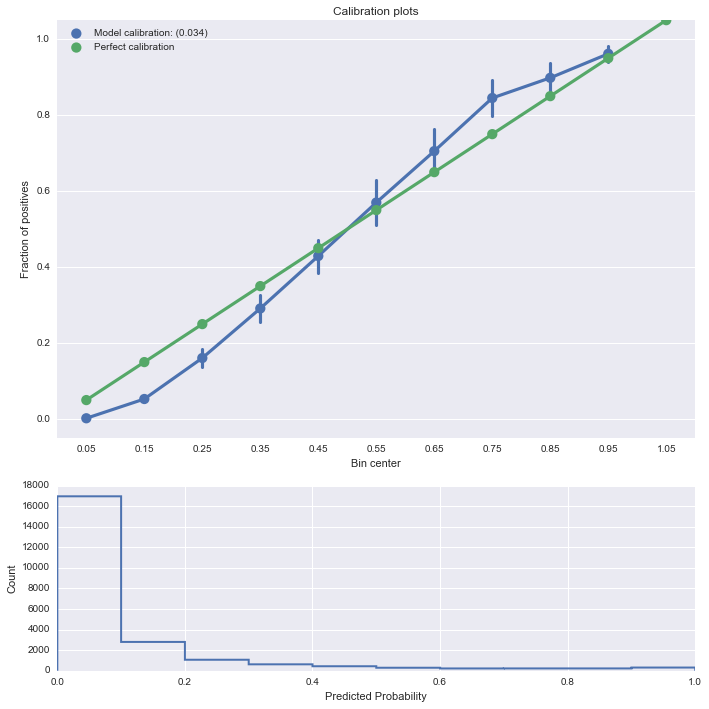

time: 5.85 s


In [26]:
y_test_oh = one_hot(y_test)
y_pred_ed = ed_linear_model.predict_proba(X_test)

if n_classes > 2:
    classes = range(n_classes)
else:
    classes = [1]

for i in classes:
    plt.figure()
    calibration_curve_plotter(y_test_oh[:, i], y_pred_ed[:, i])
    plt.show()